<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/SARIMAX%E5%AE%8C%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 時系列モデルの種類
- AR（自己回帰モデル）　　現在の値は、過去の値から決まる
- MA（移動平均モデル）　　現在の値は、過去の「実績と予測のズレ」から決まる
- ARMA（自己回帰 移動平均モデル） ...AR + MA
- ARIMA（自己回帰 和分 移動平均モデル）  ...ARMA + I(時間帯によって平均値はブレる)
- SARIMA（季節 自己回帰 和分 移動平均モデル） ...S(データに周期性がある) + ARIMA
- SARIMAX ...SARIMA + 説明変数

### データ読込と分割

In [1]:
#いろいろインポート
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from google.colab import drive
drive.mount('/content/drive')

#データ読み込み
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/時系列解析/Qiita用/☆１/SARIMAXの実装.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)

#dfのgroupby
df = df.resample("M").mean()
print(df.shape)
df

Mounted at /content/drive
(120, 3)


,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-31,7.022581,0.290323,7.158065
2010-02-28,6.500000,4.107143,4.225000
2010-03-31,9.096774,4.629032,4.509677
2010-04-30,12.393333,7.133333,4.663333
2010-05-31,18.951613,3.677419,6.412903
...,...,...,...
2019-08-31,28.396774,3.548387,6.058065
2019-09-30,25.060000,6.566667,4.586667
2019-10-31,19.425806,17.080645,3.638710


分割

In [2]:
#　月ごとに集計したデータも準備しておく
df_train = df["2010":"2018"] # df_month

df = df["2010":"2019"] # df_month_all

df_test = df["2019"]   # df_month_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


### 学習

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_train["平均気温(℃)"]
X = df_train[["降水量の合計(mm)","日照時間(時間)"]]
sarima_model = sm.tsa.SARIMAX(y,X, order=(1,1,1),seasonal_order=(0,1,1,12))
result = sarima_model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            平均気温(℃)   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -141.757
Date:                            Wed, 14 Sep 2022   AIC                            295.514
Time:                                    05:12:55   BIC                            310.837
Sample:                                01-31-2010   HQIC                           301.705
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
降水量の合計(mm)    -0.0054      0.036     -0.147      0.883      -0.077       0.066
日照時間(時間)       0.3838      0.154      2.488      0.013       0.081       0.686
ar.L1          0.2493      0.119      2.103      0.035       0.017       0.482
ma.L1         -0.9988      2.105     -0.474      0.635      -5.125       3.127
ma.S.L12      -0.9971     10.902     -0.091      0.927     -22.364      20.370
sigma2         0.8261      9.761      0.085      0.933     -18.306      19.958
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.79   Prob(JB):                         0.37
Heteroskedasticity (H):               0.89   Skew:                             0.31
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### グリッドサーチ

In [ ]:
import itertools

p = q = range(0, 3)
sp = sd = sq = range(0, 2)

#p,q,sp,sd,sqの組み合わせのリストを作成する。和分=1,周期=12は固定
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y, order = param, seasonal_order = param_seasonal)
            results = mod.fit()
            print('ARIMAパラメータ{}, 季節変動パラメータ{} - AIC: {}'.format(param, param_seasonal, results.aic))
            
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

print('AIC最小のモデル：', best_result)

ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 0, 0, 12) - AIC: 613.9551631312182
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 0, 1, 12) - AIC: 528.8431011738005
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 1, 0, 12) - AIC: 359.2434101619832
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 1, 1, 12) - AIC: 333.37390920876607
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 0, 0, 12) - AIC: 427.0478625567827
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 0, 1, 12) - AIC: 403.0842838714033
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 1, 0, 12) - AIC: 351.68990322961935
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 1, 1, 12) - AIC: 334.5500870402405
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 0, 0, 12) - AIC: 560.8256802210583
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 0, 1, 12) - AIC: 505.9826928198994
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 1, 0, 12) - AIC: 321.08895893648213
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 1, 1, 12) - AIC: 306.8216431466753
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(1, 0, 0, 12) - AIC: 402.1304495137347
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(1, 0, 1, 12) - AIC: 387.9467990151249
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(

### 波形の予測

[exogは独立変数（説明変数）](https://it.senatus.jp/statsmodels%E3%81%AEendog%E3%82%84%E3%80%81exog%E3%81%A8%E3%81%AF%E4%BD%95%E3%81%8B%EF%BC%9F/)

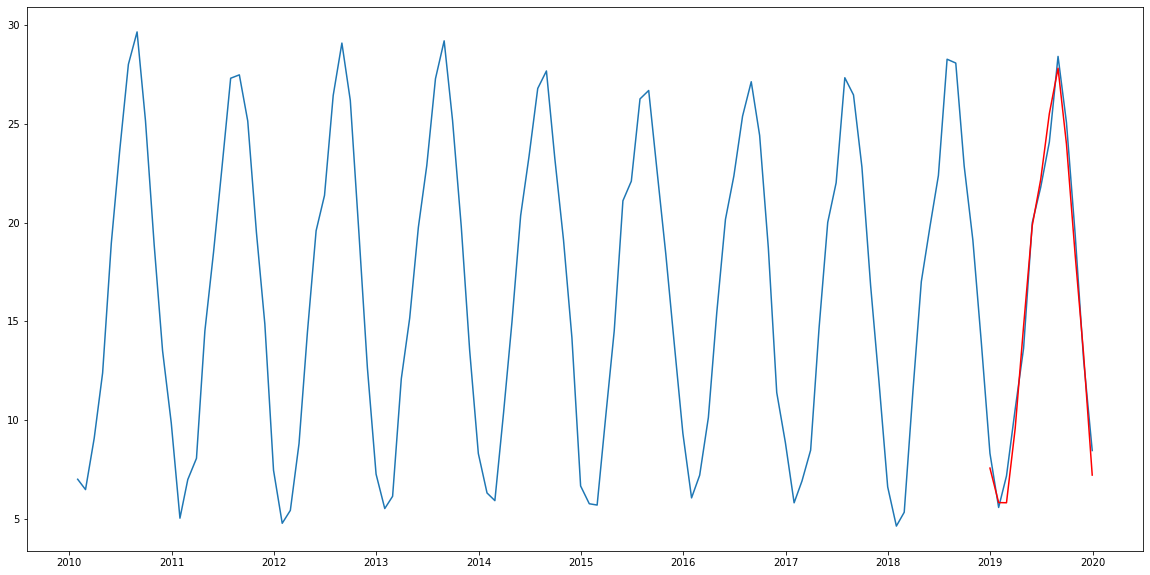

In [ ]:
plt.figure(figsize=(20,10))
bestPred = result.predict('2018-12', '2019-12',exog=df_test[["降水量の合計(mm)","日照時間(時間)"]])
plt.plot(df["平均気温(℃)"])
plt.plot(bestPred, "r")

In [ ]:
bestPred = pd.DataFrame(bestPred)
bestPred

,predicted_mean
2018-12-31,7.586499
2019-01-31,5.843569
2019-02-28,5.834012
2019-03-31,9.583526
2019-04-30,14.758296
2019-05-31,19.846008
2019-06-30,22.163614
2019-07-31,25.507568
2019-08-31,27.799539
2019-09-30,23.975673


In [ ]:
bestPred = bestPred[1:]
bestPred

,predicted_mean
2019-01-31,5.843569
2019-02-28,5.834012
2019-03-31,9.583526
2019-04-30,14.758296
2019-05-31,19.846008
2019-06-30,22.163614
2019-07-31,25.507568
2019-08-31,27.799539
2019-09-30,23.975673
2019-10-31,18.383389


In [ ]:
test_for_pred = df_test["平均気温(℃)"]
test_for_pred

年月日
2019-01-31     5.596774
2019-02-28     7.189286
2019-03-31    10.561290
2019-04-30    13.640000
2019-05-31    19.993548
2019-06-30    21.773333
2019-07-31    24.070968
2019-08-31    28.396774
2019-09-30    25.060000
2019-10-31    19.425806
2019-11-30    13.100000
2019-12-31     8.474194
Freq: M, Name: 平均気温(℃), dtype: float64

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
test = df_test["平均気温(℃)"]
print("RMSE",np.sqrt(MSE(test_for_pred,bestPred)))

RMSE 0.9389284544174549
